Build emulator for the SVD components of $\{ P_0(k | \theta_i) \}_{i \in LHD}$ for 1 dimensions of $\theta$ (for simplicity)

In [1]:
import os 
import pickle
import numpy as np 
import scipy as sp
import george as George
import nbodykit.lab as NBlab

# -- local -- 
import env
import lhd as LHD
import data as Dat
import compress as Cmprs
import forwardmodel as FM 

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
    mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# designate random seed
seed = 10
np.random.seed(seed)

Functions for contructing $P(k|\theta)$

In [4]:
def BigF(theta, halos): 
    # F(theta) --- i.e. the galaxy catalog generated
    # from the halo catalog
    p_hod = {'logMmin': theta[0], 'sigma_logM': theta[1], 'logM0': theta[2], 'logM1': theta[3], 'alpha': theta[4]}
    g = FM.Galaxies(halos, p_hod, seed=seed)
    g['RSDPosition'] = FM.RSD(g, LOS=[0,0,1]) # impose RSD
    return g

def ObvsBigF(bigf, obvs='p0k'):
    # measure P(k) from F(theta)
    plk_i = FM.Observables(bigf, observable='plk', Nmesh=360, rsd=True)
    klim = np.where((plk_i['k'] > 0.01) & (plk_i['k'] < 0.5))
    return plk_i['k'][klim], plk_i['p0k'][klim]

Lets begin by reading in/constructing $\{\theta_i\}^{LHD}$s of the Latin Hypercube Design and $P_0(k|\{\theta_i\}^{LHD})$ which will be used to train the GP.

In [5]:
f_lhd = 'pc_emulator_1d_lhd.p'
if os.path.isfile(f_lhd): 
    data_lhd = pickle.load(open(f_lhd, 'rb'))
    theta_lhd = data_lhd['theta']
    pk_lhd = data_lhd['pk']
    karr = data_lhd['k']
else: 
    # 1D Latin Hypercube Design
    lhd_1d = LHD.LHD(1, samples=17, method='mdu')
    # make thetas
    theta_lhd = np.zeros((lhd_1d.shape[0], 5))
    theta_lhd[:,0] = 11.60 # log M_min
    theta_lhd[:,1] = 0.26  # sigma_logM
    theta_lhd[:,2] = 11.49 # log M0
    theta_lhd[:,3] = 12.2 + lhd_1d.flatten()  # log M1 sampled by LHD
    theta_lhd[:,4] = 1.# + lhd_2d[:,1].flatten() # alpha sampled by LHD
    
    # Read in halo catalog
    halos = Dat.NeutHalos(0.0, 1, 4)
    pk_lhd = []
    for i in range(theta_lhd.shape[0]): 
        gals_i = BigF(theta_lhd[i,:], halos)
        kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
        pk_lhd.append(p0k_i)
        if i == 0: karr = kk
    pk_lhd = np.array(pk_lhd)
    
    data_lhd = {} 
    data_lhd['theta'] = theta_lhd
    data_lhd['pk'] = pk_lhd
    data_lhd['k'] = karr
    
    pickle.dump(data_lhd, open(f_lhd, 'wb'))

Lets begin by reading in/constructing $\{\theta_i\}^{test}$s of the Latin Hypercube Design and $P_0(k|\{\theta_i\}^{test})$ which will be used to test the GP.

In [6]:
f_test = 'pc_emulator_1d_test.p'
if os.path.isfile(f_test): 
    data_test = pickle.load(open(f_test, 'rb'))
    theta_test = data_test['theta']
    pk_test = data_test['pk']
else: 
    # make thetas
    theta_test = np.zeros((10, theta_lhd.shape[1]))
    theta_test[:,0] = 11.60 # log M_min
    theta_test[:,1] = 0.26  # sigma_logM
    theta_test[:,2] = 11.49 # log M0
    ti = np.linspace(12.5, 12.9, theta_test.shape[0])
    theta_test[:,3] = ti 
    theta_test[:,4] = 1.
    
    # Read in halo catalog
    halos = Dat.NeutHalos(0.0, 1, 4)
    pk_test = []
    for i in range(theta_test.shape[0]): 
        gals_i = BigF(theta_test[i,:], halos)
        kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
        pk_test.append(p0k_i)
        if i == 0: karr = kk
    pk_test = np.array(pk_test)
    
    data_test = {} 
    data_test['theta'] = theta_test
    data_test['pk'] = pk_test
    data_test['k'] = karr
    
    pickle.dump(data_test, open(f_test, 'wb'))

In [49]:
keylist = ['$\log\,M_{min}$', '$\sigma_{\log M}$', r'$\log M_0$', r'$\log M_1$', r'$\alpha$']
print keylist
print theta_lhd[:5,:]
print theta_test[:5,:]

['$\\log\\,M_{min}$', '$\\sigma_{\\log M}$', '$\\log M_0$', '$\\log M_1$', '$\\alpha$']
[[ 11.6          0.26        11.49        12.92501078   1.        ]
 [ 11.6          0.26        11.49        12.30174154   1.        ]
 [ 11.6          0.26        11.49        12.4727975    1.        ]
 [ 11.6          0.26        11.49        12.36983604   1.        ]
 [ 11.6          0.26        11.49        12.63954205   1.        ]]
[[ 11.6          0.26        11.49        12.5          1.        ]
 [ 11.6          0.26        11.49        12.54444444   1.        ]
 [ 11.6          0.26        11.49        12.58888889   1.        ]
 [ 11.6          0.26        11.49        12.63333333   1.        ]
 [ 11.6          0.26        11.49        12.67777778   1.        ]]


In [50]:
pk_lhd = pk_lhd[:,10:]
pk_test = pk_test[:,10:]
karr = karr[10:]

Here's what the $P(k|\theta_i)$s look like

(0.5, 1.5)

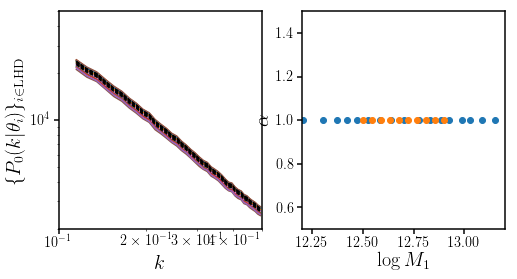

In [9]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
for i in range(pk_lhd.shape[0]): 
    sub.plot(karr, pk_lhd[i,:])
for i in range(pk_test.shape[0]):
    sub.plot(karr, pk_test[i,:], c='k', ls='--', lw=1)
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.1, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{LHD}}$', fontsize=20)
sub.set_ylim([2e3, 5e4])
sub.set_yscale('log')

sub2.scatter(theta_lhd[:,3], theta_lhd[:,4])
sub2.scatter(theta_test[:,3], theta_test[:,4])
sub2.set_xlabel(keylist[3], fontsize=20)
sub2.set_xlim([12.2, 13.2])
sub2.set_ylabel(keylist[4], fontsize=20)
sub2.set_ylim([0.5, 1.5])

(12.2, 13.2)

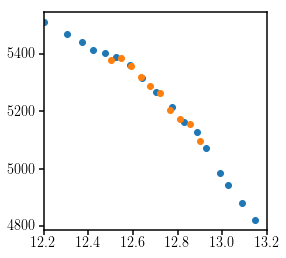

In [51]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)
sub.scatter(theta_lhd[:,3], pk_lhd[:,10])
sub.scatter(theta_test[:,3], pk_test[:,10])
sub.set_xlim([12.2, 13.2])

Get the SVD components of the LHD.

In [27]:
n_comp = 1
svd_lhd = Cmprs.Svd(n_comp=n_comp)
_ = svd_lhd.fit(pk_lhd)

In [28]:
X_lhd = svd_lhd._white(pk_lhd)
X_test = svd_lhd._white(pk_test)

$\{P(k|\theta_i)\}_{i\in LHD}$ whitened by subtracting out the mean and scaling by the standard deviation

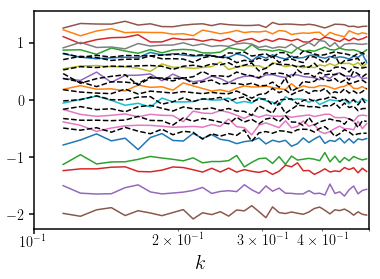

In [29]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_lhd.shape[0]): 
    sub.plot(karr, X_lhd[i,:])
for i in range(pk_test.shape[0]): 
    sub.plot(karr, X_test[i,:], c='k', ls='--')
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.1, 0.5])
sub.set_xscale('log')

In [30]:
pc_lhd = svd_lhd.transform(pk_lhd)
pc_test = svd_lhd.transform(pk_test)

In [31]:
# explained variance
print svd_lhd.n_comp, ' components'
print svd_lhd.exp_var_ratio[:n_comp]

1  components
[ 0.99813265]


Test SVD transformation

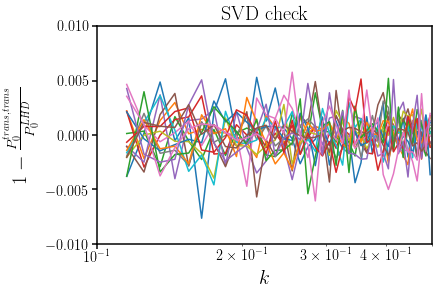

In [33]:
pc_lhd_inv = svd_lhd.inv_transform(pc_lhd)
pc_test_inv = svd_lhd.inv_transform(pc_test)
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pc_lhd.shape[0]): 
    sub.plot(karr, 1.-pc_lhd_inv[i,:]/pk_lhd[i,:])
sub.set_xlabel('$k$', fontsize=20)
sub.set_xscale('log')
sub.set_xlim([0.1,0.5])
sub.set_ylabel(r'$1 - \frac{P_0^{trans,trans}}{P_0^{LHD}}$', fontsize=20)
sub.set_ylim([-0.01, 0.01])
sub.set_title("SVD check", fontsize=20)

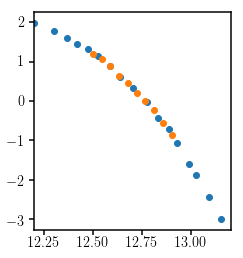

In [34]:
fig = plt.figure(figsize=(12,4))
for i in range(np.min([svd_lhd.n_comp, 3])):
    sub = fig.add_subplot(1,3,i+1)
    sub.scatter(theta_lhd[:,3], pc_lhd[:,i])
    sub.scatter(theta_test[:,3], pc_test[:,i])
    sub.set_xlim([12.2, 13.2])

In [35]:
def trainGP(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    if len(X.shape) == 1: 
        lguess = (np.max(X) - np.min(X))/float(len(X))
    else: 
        lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]
    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        gps.append(gp)
    return gps

def trainGP_opt(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    if len(X.shape) == 1: 
        lguess = (np.max(X) - np.min(X))/float(len(X))
    else: 
        lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]
    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_kernel=True, fit_mean=True)
        gp.compute(X)
        # optimize hyperparameters
        p0 = gp.get_parameter_vector()
        results = sp.optimize.minimize(gp.nll, p0, args=(Y[:,i]), jac=gp.grad_nll, method='L-BFGS-B')
        gp.set_parameter_vector(results.x)
        gps.append(gp)
    return gps

def emu(x_pred, gps, Y): 
    # use GPs to predict Plk at x_pred
    mus, vs = [], [] 
    for i, gp in enumerate(gps): 
        mu, var = gp.predict(Y[:,i], x_pred)
        mus.append(mu)
        vs.append(var)
    return np.array(mus).T, np.array(vs).T

In [39]:
# train Gaussian processes on the LHD
gp_emu = trainGP_opt(theta_lhd[:,3].reshape(-1,1), pc_lhd)

In [40]:
# now evaluate at the test points
pc_test_pred, var_test_pred = emu(theta_test[:,3].reshape(-1,1), gp_emu, pc_lhd)

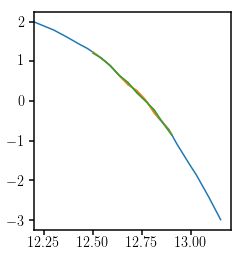

In [41]:
fig = plt.figure(figsize=(12,4))

isort_lhd = np.argsort(theta_lhd[:,3])
isort_test= np.argsort(theta_test[:,3])

for i in range(np.min([svd_lhd.n_comp, 3])):
    sub = fig.add_subplot(1,3,i+1)
    sub.plot(theta_lhd[:,3][isort_lhd], pc_lhd[:,i][isort_lhd])
    sub.plot(theta_test[:,3][isort_test], pc_test_pred[:,i][isort_test])#, yerr=np.sqrt(np.diag(var_test_pred)))
    sub.plot(theta_test[:,3][isort_test], pc_test[:,i][isort_test])
    sub.set_xlim([12.2, 13.2])

(-0.025, 0.025)

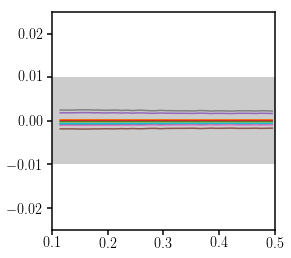

In [48]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)

#sub.plot(karr, pc_lhd_inv)
pc_test_pred_inv = svd_lhd.inv_transform(pc_test_pred)
for i in range(pc_test_pred_inv.shape[0]):
    sub.plot(karr, 1.-pc_test_pred_inv[i,:]/pc_test_inv[i,:])
sub.fill_between([0.1, 0.5], [-0.01, -0.01], [0.01, 0.01], color='k', alpha=0.2, linewidth=0)
sub.set_xlim([0.1, 0.5])
sub.set_ylim([-0.025, 0.025])